# A Beginner's Analysis of Chess

# Introduction
Chess is a game that is often described as being about patterns. Most people train for years to try and develop an intuitive feel for how those patterns play out inside a particular game, to the point where experts say they can often see the next move without having to even really think about it. However, for the sake of not spending years to achieve this, we might be interested in finding shortcuts when it comes to making decisions in chess. However, in a game with over one thousand three hundred and twenty seven named openings (Oxford Companion to Chess), it seems that the search space is a little too extreme for human hands.

With this in mind, we can apply data science to the problem of finding shortcuts for us, almost as a shortcut to shortcuts.

# Data Collection
Having the goal of looking at chess, we need some way to get a lot of data on chess games. The popular chess website lichess is a good source of data, and fortunately there already exists a dataset on Kaggle of chess games pulled from lichess. For those interested, the link is https://www.kaggle.com/datasets/datasnaek/chess. If you'd like to learn about how they did it, it involved using the lichess api documented here https://github.com/lichess-org/lila. Now, from here we can download the "games.csv" file containing all the data, and import it into our notebook as a pandas dataframe as so:

In [1]:
import pandas as pd

#Reads in chess data into pandas dataframe
df = pd.read_csv("games.csv")
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


Now having done this, a few important questions need to be addressed about our data. Are any of the entries in our table NaN, and do all of our rows represent unique games? We can answer both of these questions with the following code: 

In [2]:
#Prints out count of NaN entries in each column of df
print(df.isna().sum(), "\n")

#Calculates percentage of rows that have duplicate game ids
percent_repeat = 100*abs(len(df["id"].unique()) - df["id"].count())/df["id"].count()

print("%.2f percent" % percent_repeat)

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64 

4.71 percent


The first line counts how many entries in each column are NaN and outputs the result. The code then computes what percentage of the rows are repeat Game IDs and outputs this. It looks like 4.71% of the rows are repeats, which will be important to keep in mind as we go.

# Data Management
To orient ourselves, we're going to focus on figuring out what the best opening is for white based on our dataset. To help us, we're going to add a column to our dataset called "winner" that contains a 1 when white won a game, and a 0 otherwise. Now we could do our analysis on all the games in our dataset, but when trying to figure out the best opening, games that had a significant skill disadvantage at play might be harmful to our analysis. Considering this, we're going to add another column called "is_fair" which is just a boolean that measures whether the ELO rating difference between the two players is less than 200. Having this allows us to filter the focus of our data analysis to similar skill level games when necessary. To that end, we'll also create a new dataframe that only contains games that are "fair" (ELO difference less than 200).

In [3]:
#Creates a new column that is 1 whenever white wins a game, and 0 otherwise
df["winner"] = df.apply(lambda row: int(row["winner"] == "white"), axis=1)

#Creates a new column containing a boolean measuring whether the ELO difference between players is less than 200
df["is_fair"] = abs(df["white_rating"] - df["black_rating"]) < 200

#Creates a new dataset only containing "fair" (ELO difference < 200) games
fair_df = df[df["is_fair"]]
fair_df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,is_fair
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,0,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,True
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,1,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,True
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,1,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,True
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,1,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,True
6,qwU9rasv,True,1.504230e+12,1.504230e+12,33,resign,1,10+0,capa_jr,1520,daniel_likes_chess,1423,d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...,D00,Blackmar-Diemer Gambit: Pietrowsky Defense,10,True


Having done all this, we can now start to do data analysis on our chess games.

# Exploratory Data Analysis
An easy first question we might have about the data set is what the average win rate is our white, and if this changes when we restrict our focus only to fair games. It's also important that we check to make sure that our focus on fairness hasn't left us with too small of a dataset to do analysis with.

In [4]:
#The mean of our winner column works out to be exactly the win rate for white
print("The average win rate for white over all the games is", df["winner"].mean())

print("The data set contains", len(fair_df.index), "games with an ELO difference less than 200.")
print("The average win rate for white over all fair games is", fair_df["winner"].mean())

The average win rate for white over all the games is 0.49860404826004584
The data set contains 13708 games with an ELO difference less than 200.
The average win rate for white over all fair games is 0.49365334111467757


It looks like we still have a reasonably large data set to analyze despite our focus on fairness, and we've already stumbled upon an interesting pattern in the data. The fact that the average win rate is higher when we consider unfair games implies that in games with a skill disadvantage its more advantageous to play as white. This matches with what we might expect, but it's also important to keep in mind that the difference is much too slight to be statistically significant. Now considering that we want to look at how openings affect win rates, we should check to see what the ratio looks like between games in our dataset and unique openings present in our dataset. 

We can calculate both like so, for both overall games and just for fair games:

In [5]:
#Calculates number of games and unique openings and the ratio of the two
print("Number of overall games:", df["opening_eco"].count())
print("Number of overall unique openings:", len(df["opening_eco"].unique()))
print("Ratio of the two:", df["opening_eco"].count()/len(fair_df["opening_eco"].unique()), "\n")

#Does the same thing except for fair games instead
print("Number of fair games:", fair_df["opening_eco"].count())
print("Number of unique openings in fair games:", len(fair_df["opening_eco"].unique()))
print("Ratio of the two:", fair_df["opening_eco"].count()/len(fair_df["opening_eco"].unique()), "\n")

#Creates a list containing openings which appear in our overall dataset but not the fair games
play_opens = [x for x in df["opening_eco"].unique() if x not in fair_df["opening_eco"].unique()]
print("This already presents an interesting difference, since these openings were only played in games where \
the ELO difference \nwas greater than 200:", play_opens)

Number of overall games: 20058
Number of overall unique openings: 365
Ratio of the two: 59.16814159292036 

Number of fair games: 13708
Number of unique openings in fair games: 339
Ratio of the two: 40.43657817109145 

This already presents an interesting difference, since these openings were only played in games where the ELO difference 
was greater than 200: ['A67', 'D48', 'E44', 'A33', 'A97', 'E42', 'E06', 'B58', 'A59', 'D47', 'D81', 'D38', 'C09', 'E95', 'C32', 'E18', 'D95', 'D57', 'D22', 'C94', 'E72', 'E63', 'A91', 'C04', 'E48', 'D19']


Now I pointed out above that some openings were only played in games where the ELO difference was greater than 200. I think this could be interesting as an aside just because it might hint towards these openings having something worth looking into. However, for our purposes of finding the best opening for white, they aren't very important. Having done all of this though, we are nearly ready to get into the thick of the data analysis.

The last thing we want to do though is make sure that we're only judging openings that were represented well in our data, as it doesn't make much sense to say that an opening with a 100% win rate that is only played out once in our data is well supported as the best possible opening for white. To that end, we want to get a frequency count for each opening, and for our purposes we'll only consider openings for which we have at least 20 games in our data. In effect, we're going to use this to add a column to our dataset, "common_open", which states whether a game used an opening which is common in our dataset (at least 20 games used it).

In [6]:
#We group by openings and count the number of games each opening has
opening_freq = fair_df.groupby(by="opening_eco", axis = 0)["id"].count()
#This creates a list of openings for which we have at least 20 fair games for (we'll call these common)
abundant_open = opening_freq[opening_freq >= 20].index

#This creates a new column in our both of our datasets marking whether the opening used is coomon
is_common = fair_df.apply(lambda row: row["opening_eco"] in abundant_open, axis = 1)
df = df.assign(common_open = is_common)
fair_df = fair_df.assign(common_open = is_common)
fair_df["common_open"].head()

1    True
2    True
3    True
4    True
6    True
Name: common_open, dtype: bool

Alright, we now have all the tools to filter out which games we think are useful for the question of best opening for white. They have to be fair games, so we'll be using our fair_df, and they have to be common openings, so we'll be querying our dataframe for rows with common_open true. Using this, we can compute the white winning rates for each opening and then create a histogram and violin plot of the results like so:

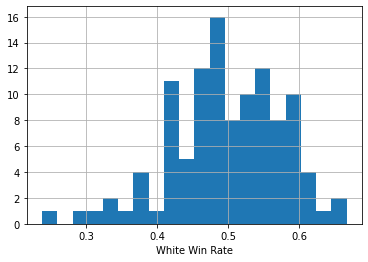

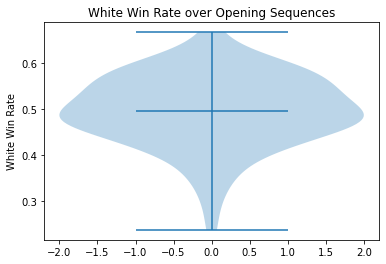

In [7]:
#We filter out for fair games which have common openings, then group by openings and compute the win rate for each
win_rates = fair_df[fair_df["common_open"]].groupby(by="opening_eco", axis = 0)["winner"].mean()

#Creates a histogram of win rates over the openings
win_rates.hist(bins=20).set_xlabel("White Win Rate")

#This creates a violin plot for the win rates over the openings
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.violinplot(win_rates.to_numpy(),[0],widths=4,showmeans=True)
ax.set_xlabel("")
ax.set_ylabel("White Win Rate")
ax.set_title("White Win Rate over Opening Sequences")
fig.savefig("violin.png")

If you aren't familar with a violin plot, it's essentially a box and whisker plot with the width of the surrounding area representing how much of the data falls at that height. In other words, it has a density distribution layed over top it. If you're interested in learning more, here's a link that goes into more detail: https://mode.com/blog/violin-plot-examples/#:~:text=What%20is%20a%20violin%20plot%3F,the%20density%20of%20each%20variable. Looking at this, it's seems like white win rates are skewed left and centered right of around 0.5, meaning that most opening sequences are good for white, but a few are pretty terrible.

Unfortunately, it doesn't look like there are any guaranteed winning strategies to be found for white in our data though, since the highest win rate is still less than 0.7. Now while these plots tell a lot about the situation, we might still want to get more precise numbers for our distribution of white winning rates over opening sequences, and we still want to know what the best opening sequence was for white. We can use pandas to answer both of these questions as follows:

In [8]:
#This sorts the openings by their win_rates, then we print out the statistical summary and the top and bottom 5
win_rates = win_rates.sort_values(ascending = False)

print(win_rates.describe(), "\n")

print(win_rates.head(), "\n")

print(win_rates.tail())

count    110.000000
mean       0.496638
std        0.078354
min        0.238095
25%        0.455195
50%        0.497170
75%        0.550000
max        0.666667
Name: winner, dtype: float64 

opening_eco
A13    0.666667
C24    0.646341
C70    0.636364
C34    0.617021
B33    0.612903
Name: winner, dtype: float64 

opening_eco
A03    0.338710
A46    0.333333
D10    0.308824
C54    0.281250
D43    0.238095
Name: winner, dtype: float64


From here, we finally have an answer to our question of the best opening for white based on our data. It is apparently A13, which is the English Opening of 1. c4 e6. Some close alternatives are C24: Bishop's Opening of 1. e4 e5 2. Bc4 Nf6, C70: Ruy Lopez of 1.e4 e5 2.Nf3 Nc6 3.Bb5 a6 4.Ba4, C34: King's Gambit of 1.e4 e5 2.f4 exf4 3.Nf3, and B33: Sicillian Defense of 1.e4 c5 2.Nf3 Nc6 3.d4 cxd4 4.Nxd4 Nf6.

However, it's a fair question as to whether or not these results are statistically significant. It's a little complicated as to how exactly we should answer this question, but the approach I'll take is to check whether each of our top 5 openings performed significantly better than the worst, D43, in our dataset. We can check this by doing an independent T-test between the sample of games for each opening sequence. If you're interested in learning more about what an independent T-test does, look here: 

https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php#:~:text=The%20independent%20t%2Dtest%2C%20also,means%20in%20two%20unrelated%20groups

If you'd like to learn more about the implementation of it in python, look here: 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

This essentially considers the idea that our best opening sequence has the same average win rate as our worst opening sequence. This is called our null-hypothesis, and a T-test calculates the probability that this is true, which we call the p-value.

In [9]:
#This creates Series containing the results of games using each opening
a13_wins = fair_df[fair_df["opening_eco"] == "A13"]["winner"]
c24_wins = fair_df[fair_df["opening_eco"] == "C24"]["winner"]
c70_wins = fair_df[fair_df["opening_eco"] == "C70"]["winner"]
c34_wins = fair_df[fair_df["opening_eco"] == "C34"]["winner"]
b33_wins = fair_df[fair_df["opening_eco"] == "B33"]["winner"]
d43_wins = fair_df[fair_df["opening_eco"] == "D43"]["winner"]

from scipy import stats

#Carries out an independent t-test w/ no assumption of equal variance between the samples (seems reasonable)
print(stats.ttest_ind(a13_wins, d43_wins, equal_var = False))
print(stats.ttest_ind(c24_wins, d43_wins, equal_var = False))
print(stats.ttest_ind(c70_wins, d43_wins, equal_var = False))
print(stats.ttest_ind(c34_wins, d43_wins, equal_var = False))
print(stats.ttest_ind(b33_wins, d43_wins, equal_var = False))

Ttest_indResult(statistic=3.451342449813167, pvalue=0.0012214328817103698)
Ttest_indResult(statistic=3.743594964252896, pvalue=0.0006796259988501868)
Ttest_indResult(statistic=3.446232742032152, pvalue=0.0013485642629498015)
Ttest_indResult(statistic=3.1790504332707754, pvalue=0.002736168285661245)
Ttest_indResult(statistic=2.8764466253915515, pvalue=0.006051984577003894)


Since all of our p-values were less than 0.05 (this is somewhat arbitrary but is typically considered a good threshold for statistical significance), our best opening sequences were statistically significantly better than the worst.

Having figured out how to win, a natural question is how to dominate. In other words, what opening sequence in our data set leads to the quickest wins. To analyze this question, we need to create a new column in our dataset representing the duration of each game, which can be done like so:

In [10]:
import datetime

#This converts the UNIX time codes for start and end of games in our table to datetimes
df["created_at_dt"] = pd.to_datetime(df["created_at"]/1000, 
                                           unit='s', 
                                           origin='unix')

df["last_move_at_dt"] = pd.to_datetime(df["last_move_at"]/1000, 
                                             unit='s', 
                                             origin='unix')

#Computes the duration of each game as a datetime.timedelta
df["duration"] = df["last_move_at_dt"] - df["created_at_dt"]

#Updates fair_df with these new durations
fair_df = df[df["is_fair"]]

#Prints out the head and tail of this new column to illustrate a problem in the data
print(df["duration"].head(), "\n")
print(df["duration"].tail())

0   0 days
1   0 days
2   0 days
3   0 days
4   0 days
Name: duration, dtype: timedelta64[ns] 

20053   0 days 00:05:21.733999872
20054   0 days 00:12:24.219000064
20055   0 days 00:02:52.833999872
20056   0 days 00:15:46.698999808
20057   0 days 00:12:16.699000064
Name: duration, dtype: timedelta64[ns]


In the code above I used a library in python called datetime which is often useful. If you'd like to learn more about it, a good source is its documentation linked here:

https://docs.python.org/3/library/datetime.html

Having done all of this, we now have to step back and check to see if there are any issues with this data. It should be clear that something is at issue when the first five games were instantaneous. The easiest solution to this is to just ignore games that had 0 duration from our dataset. After having done this, we can calculate an interesting summary statistic of how long an average game takes.

In [11]:
#Calculates the number of games that recorded 0 duration
zero_time = datetime.timedelta(0)
print(df[df["duration"] == zero_time]["id"].count(), "games have duration recorded as 0.")

#Creates a new dataset only containing games with nonzero duration
valid_games = df[df["duration"] != zero_time]

#Computes and print the average duration over all games and over all fair games
print("The average duration over all games with recorded durations is", valid_games["duration"].mean())
print("The average duration over all fair games with recorded durations is", valid_games[valid_games["is_fair"]]\
      ["duration"].mean())

8548 games have duration recorded as 0.
The average duration over all games with recorded durations is 0 days 00:25:15.602432751
The average duration over all fair games with recorded durations is 0 days 00:24:30.311214839


It looks like the average game of online chess took 25 minutes and 15 seconds, and if we consider "fair" games, this drops to 24 minutes and 30 seconds. Focusing back on our goal though, we can repeat the same process we did with win-rates to create a histogram and violin plot of durations over our opening sequences like so:

opening_eco
A00   0 days 00:20:41.847167742
A01   0 days 00:33:26.277264685
A02   0 days 00:37:58.791222257
A03   0 days 00:08:38.914461518
A04   0 days 00:21:59.884254524
                 ...           
D45   0 days 00:09:21.942199910
E00   0 days 00:17:15.277499968
E20   0 days 00:25:24.878777770
E61   0 days 00:42:55.965090816
E90   0 days 00:15:32.708600012
Name: duration, Length: 110, dtype: timedelta64[ns]


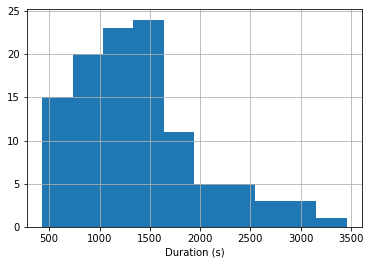

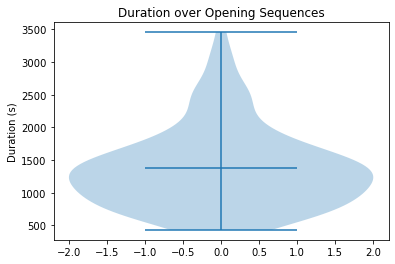

In [13]:
#Creates a new dataset only containing fair games that white won which had nonzero duration
valid_fair_wins_df = fair_df[fair_df["duration"] != zero_time]
valid_fair_wins_df = valid_fair_wins_df[valid_fair_wins_df["winner"] == 1]

#Calculates the average duration for each opening sequence that we consider common (>= 20 fair games)
durations = valid_fair_wins_df[valid_fair_wins_df["common_open"]].groupby(by="opening_eco", axis = 0)["duration"].mean()

print(durations)

#Converts each duration into seconds to make it easier to display
durations = durations.apply(lambda x: x.total_seconds())
durations.hist(bins=10).set_xlabel("Duration (s)")

fig, ax = plt.subplots()

ax.violinplot(durations.to_numpy(),[0],widths=4,showmeans=True)
ax.set_xlabel("")
ax.set_ylabel("Duration (s)")
ax.set_title("Duration over Opening Sequences")
fig.savefig("violin.png")

Disregarding an outlier around 4000, our distribution seems to be symmetric and unimodal around 1500. This lends credence to the idea that opening sequences might not have a significant effect on winning time, as the data is nearly normally distributed. This matches what we would expect if they all had the same average winning time. Continuing onwards despite this though, we can find which opening sequences took the longest and the least amount of time to win:

In [15]:
#This sorts the openings by their durations, then we print out the statistical summary and the top and bottom 5
durations = durations.sort_values(ascending = False)

print(durations.describe(), "\n")

print(durations.head(), "\n")

print(durations.tail())

count     110.000000
mean     1371.143961
std       617.182891
min       429.580999
25%       933.371950
50%      1311.869555
75%      1647.066873
max      3457.307749
Name: duration, dtype: float64 

opening_eco
B57    3457.307749
C78    3069.521500
A43    3045.544153
A46    2921.289200
B54    2601.182923
Name: duration, dtype: float64 

opening_eco
C61    597.185333
C27    563.369777
D45    561.942199
A03    518.914461
C77    429.580999
Name: duration, dtype: float64


It looks like A20 was the outlier in the plots, taking 4375 seconds or about 73 minutes to finish its games. Considering the earlier unreliability of our data, this should probably be taken with a grain of salt. However, we can now say that the quickest winning opening sequences are A49, C22, B52, C58, and C26. Considering the plots though, it's important to see what a T-Test says about the significance of this result. We'll proceed in the exact same way as we did before, however due to the suspect nature of A20 we'll use A07 instead.

In [14]:
#This creates Series containing the durations of games using each opening
a07_durations = valid_fair_wins_df[valid_fair_wins_df["opening_eco"] == "A07"]["duration"]
c26_durations = valid_fair_wins_df[valid_fair_wins_df["opening_eco"] == "C26"]["duration"]
c58_durations = valid_fair_wins_df[valid_fair_wins_df["opening_eco"] == "C58"]["duration"]
b52_durations = valid_fair_wins_df[valid_fair_wins_df["opening_eco"] == "B52"]["duration"]
c22_durations = valid_fair_wins_df[valid_fair_wins_df["opening_eco"] == "C22"]["duration"]
a49_durations = valid_fair_wins_df[valid_fair_wins_df["opening_eco"] == "A49"]["duration"]

#Converts the durations to seconds to make the t-tests work
a07_durations = a07_durations.apply(lambda x: x.total_seconds())
a49_durations = a49_durations.apply(lambda x: x.total_seconds())
c22_durations = c22_durations.apply(lambda x: x.total_seconds())
b52_durations = b52_durations.apply(lambda x: x.total_seconds())
c58_durations = c58_durations.apply(lambda x: x.total_seconds())
c26_durations = c26_durations.apply(lambda x: x.total_seconds())

#Carries out an independent t-test w/ no assumption of equal variance between the samples (seems reasonable)
print(stats.ttest_ind(a07_durations.to_numpy(), a49_durations.to_numpy(), equal_var = False))
print(stats.ttest_ind(a07_durations.to_numpy(), c22_durations.to_numpy(), equal_var = False))
print(stats.ttest_ind(a07_durations.to_numpy(), b52_durations.to_numpy(), equal_var = False))
print(stats.ttest_ind(a07_durations.to_numpy(), c58_durations.to_numpy(), equal_var = False))
print(stats.ttest_ind(a07_durations.to_numpy(), c26_durations.to_numpy(), equal_var = False))

Ttest_indResult(statistic=1.0322508140838718, pvalue=0.3485519892237561)
Ttest_indResult(statistic=1.042227868315162, pvalue=0.3448247098492884)
Ttest_indResult(statistic=1.0376048785694147, pvalue=0.3452792151233667)
Ttest_indResult(statistic=0.8117412119782935, pvalue=0.4531322660525688)
Ttest_indResult(statistic=1.0016862051799895, pvalue=0.3621814680149846)


In this case, it looks like none of our results were significantly significant. Even though this is unfortunate, it serves as an important example of how even seemingly significant differences in results (about ~2000-3000 seconds) may not be statistically significant.

# Conclusion
For those of us who aren't nearly experts in chess, this data set does seem to have an answer for which opening sequences we should aim for when playing white. To summarize, we should hope for the English Opening of 1. c4 e6, but we wouldn't be that bad off with any of the following:

    Bishop's Opening of 1. e4 e5 2. Bc4 Nf6,
    Ruy Lopez of 1.e4 e5 2.Nf3 Nc6 3.Bb5 a6 4.Ba4,
    King's Gamit of 1.e4 e5 2.f4 exf4 3.Nf3,
    Sicillian Defense of 1.e4 c5 2.Nf3 Nc6 3.d4 cxd4 4.Nxd4 Nf6.
    
We tried to analyze our data set for which opening sequence had the best winning time, but unfortunately the data didn't support any conclusions about this. However, this could be an interesting question for any readers curious about expanding the dataset using lichess' API.